In [38]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *

In [39]:
#general settings
LSST    = False
#if not LSST redhsift kernel
z0_1      = 1.
sigma_z_1 = 0.5
z0_2      = 2.
sigma_z_2 = 0.5
bin_num1 = 'all'
bin_num2 = 'all'
zmax  = 5.
bias  = 'simple'
chimax = chi_z(zmax)
print('zmax=%d'%zmax, 'chimax=%d'%chimax)


if LSST:
    file_ext = 'lsst_%s_%s'%(str(bin_num1), str(bin_num2))
else:
    file_ext = 'gaussgal_z0%d_%d_sigmaz%d_%d'%(z0_1*10,z0_2*10,sigma_z_1*10,sigma_z_2*10)
    
file_ext2 = 'zmax%d'%zmax
    
print(file_ext, file_ext2)


params = {}
params['LSST']    = LSST
params['z01']     = z0_1
params['sigma_z1']= sigma_z_1
params['z02']     = z0_2
params['sigma_z2']= sigma_z_2
params['bin_num1']= bin_num1
params['bin_num2']= bin_num2
params['chimax']  = chimax
params['bias']    = bias
params['ext']     = file_ext
params['ext2']    = file_ext2

if bias == 'simple':
    bias_func = simple_bias
elif bias =='constant':
    bias_func = constant_bias
else:
    print('no valid bias function selected')

pickle.dump(params,open('../settings/params_%s.pkl'%file_ext,'wb'))

pickle.load(open('../settings/params_%s.pkl'%file_ext,'rb'))

zmax=5 chimax=5387
gaussgal_z010_20_sigmaz5_5 zmax5


{'LSST': False,
 'z01': 1.0,
 'sigma_z1': 0.5,
 'z02': 2.0,
 'sigma_z2': 0.5,
 'bin_num1': 'all',
 'bin_num2': 'all',
 'chimax': array(5387.18716845),
 'bias': 'simple',
 'ext': 'gaussgal_z010_20_sigmaz5_5',
 'ext2': 'zmax5'}

In [40]:
if LSST:
    kernel1 = gal_clus(dNdz_LSST, bias_func, bin_num1)
    kernel2 = gal_clus(dNdz_LSST, bias_func, bin_num2)
else:
    kernel1 = gal_clus(Gauss_redshift(sigma_z=sigma_z_1,z0=z0_1), bias_func)
    kernel2 = gal_clus(Gauss_redshift(sigma_z=sigma_z_2,z0=z0_2), bias_func)

In [4]:
L = np.logspace(np.log10(min(ell_)),np.log10(1000),100)
l = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)

(0, array(5387.18716845))

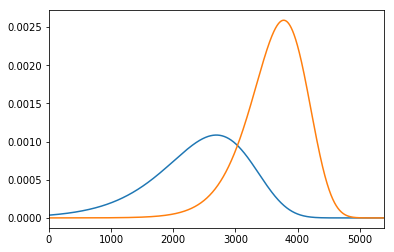

In [5]:
chis = np.linspace(1,chimax,20000)
plt.figure()
plt.plot(chis,kernel1(chis))
plt.plot(chis,kernel2(chis))
plt.xlim(0,chimax)

In [6]:
L   = np.logspace(np.log10(min(ell_)),np.log10(1000),100)
l   = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)

In [12]:
# auto spectrum
#clgg
begin=time.time()
r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

n = 4
chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Cl_gg = chimax * result/np.pi**2/2./4. #dividing by extra factor of 4 (should be there because of Gaussian Quadrature)

np.save('../output/cls/Clgg_%s.npy'%(file_ext),[ell_,Cl_gg])

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.6060082912445068


In [13]:
chi1s, chi2s, clphiphirt = np.load('../G_matrices/clphiphi_rt_%s.npy'%file_ext2)
chi1s_, chi2s_, clphiphir_over_t = np.load('../G_matrices/clphiphi_r_over_t_%s.npy'%file_ext2)
clphiphirt = np.swapaxes(clphiphirt,1,2)
clphiphir_over_t = np.swapaxes(clphiphir_over_t,1,2)

In [14]:
# this is cldeltadelta weighted by clphiphi, as it appears in the (2,2)-term
try: 
    _, Mgg22A = np.load('../M_matrices/Mgg22A_%s.npy'%file_ext)
    Mgg22A_spline = RectBivariateSpline(ell_,ell_,Mgg22A)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clphiphirt_ = np.expand_dims(clphiphirt,-1)
    clphiphir_over_t_ = np.expand_dims(clphiphir_over_t,-1)

    result = np.zeros((len(ell_),len(ell_)))

    n = 4

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*clphiphirt_[nn])
        chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphir_over_t_[nn])
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        # phiphi should be second entry, associated with l (this is after variable trafo)
        for ii  in range(ell_.size):        
            result[ii][nn] = np.sum(chifacs*I4_ltrc[ii])

    print(time.time()-begin)

    Mgg22A = chimax*result*1./np.pi**2/2./4.
    np.save('../M_matrices/Mgg22A_%s.npy'%str(file_ext),[np.meshgrid(ell_),Mgg22A])

    M22A_spline = RectBivariateSpline(ell_,ell_,Mgg22A)

In [15]:
# script: clphiphi_VB_parallel.py
clphiphi   = np.load('../G_matrices/clphiphi_parallel_%s.npy'%file_ext2)

cl_phiphi_diag= np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    cl_phiphi_diag[:,ii]=clphiphi[:,ii,ii]

clphiphi_diag=[]
from scipy.interpolate import interp1d
for ii in range(len(ell_)):
    clphiphi_diag+=[interp1d(chimax*t_,cl_phiphi_diag[ii])]

In [16]:
# this is cldeltadelta weighted by clphiphi(chi), as it appears in the (1,3a)-term
try:
    _, Mgg31a = np.load('../M_matrices/Mgg31a_%s.npy'%file_ext)
    Mgg31a_spline = RectBivariateSpline(ell_,ell_,Mgg31a)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    n = 4

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
        chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):   
            # phiphi should be second entry associated with l
            result[ii][nn] = np.sum(chifacs*I4_ltrc[ii])

    print(time.time()-begin)

    Mgg31a = chimax * result*1./np.pi**2/2./4.

    np.save('../M_matrices/Mgg31a_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg31a])

    Mgg31a_spline = RectBivariateSpline(ell_,ell_,Mgg31a)

In [17]:
def get_regularized_sum_of_terms_1(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


def get_regularized_sum_of_terms_2(L,L1,phi,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = - LL1*((LL*LL1*nu)**2-(LL*LL1*nu-LL1*LL1)**2)*(M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

In [18]:
LimberTerms = get_regularized_sum_of_terms_1(L,l,phi,Mgg22A_spline,Mgg31a_spline,method='trapz')+get_regularized_sum_of_terms_2(L,l,phi,Mgg31a_spline,method='trapz')

(1, 1000.0)

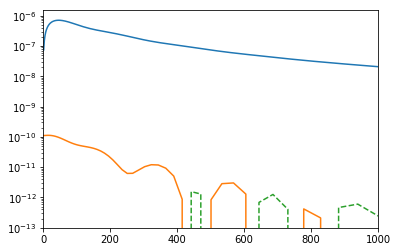

In [19]:
plt.figure()
plt.plot(ell_,Cl_gg)
plt.plot(L,LimberTerms)
plt.plot(L,-LimberTerms,ls='--')
plt.yscale('log')
plt.xlim(1,max(L))

In [94]:
# get cldeltaphi for second <22> term
try:
    assert(False)
    clphidelta = np.load('../G_matrices/clphidelta_%s.npy'%file_ext2)
except:
    
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi) * (xmax > xi)

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    chimax2  = chimax

    n = 2

    Cl = np.zeros((len(t_),len(ell_),len(t_)))

    begin=time.time()

    for jj, chimax1 in enumerate((t_*chimax)):
        if jj%10==0:
            print(jj)

        chi1fac0  = D_chi(r2d*chimax2)
        chi1fac0  = chi1fac0 *(r2d*chimax2)**(1-(n+nu_n_).reshape(1, 1, -1))
        chi2fac00 = (D_chi(r2d*t2d*chimax2)*(1+z_chi(r2d*t2d*chimax2))*inner_kernel(r2d*t2d*chimax2, chimax1))
        chi2fac01 = (inner_kernel(1./t2d*r2d*chimax2,chimax1)*D_chi(r2d*1./t2d*chimax2)*(1+z_chi(r2d*1./t2d*chimax2)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w12*chi1fac0* chi2fac0

        result    = np.zeros((len(ell_),len(t_)))
        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))

        Cl[jj] = result*1./np.pi**2/2.*prefac/2.*-2 #no chimax because not summing over r

    clphidelta = np.swapaxes(Cl,0,1)
    print('Time taken = ', time.time()-begin)


    # first axis ell, delta goes as r2d
    np.save('../G_matrices/clphidelta_%s'%file_ext2,clphidelta)
    
# phi goes as r2d
cldeltaphi = np.swapaxes(clphidelta,1,2)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  152.67468690872192


In [95]:
# this is the second term in <2,2>
try:
    #assert(False)
    _ , Mgg22B = np.load('../M_matrices/Mgg22B_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            # first index is |L-l|, clphidelta-> delta goes as r2d, goes with kernel2 -> goes with L-l
            result[ii][jj] = np.sum(w11*w12*kernel1(t2d*chimax)*kernel2(r2d*chimax)*cldeltaphi[jj]*clphidelta[ii])
    result*=chimax**2/4.

    Mgg22B = result

    # first index is L
    np.save('../M_matrices/Mgg22B_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg22B])

Mgg22B_spline = RectBivariateSpline(ell_,ell_,Mgg22B)

In [108]:
# clpsigalaxy, kernel2
try:
    assert(False)
    clpsigal2 = np.load('../G_matrices/clpsigal_%s_2d_kernel2.npy'%(file_ext))
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    n = 2
    
    begin=time.time()
    result=np.zeros((len(t_),len(ell_),len(t_)))
    
    for jj, tt in enumerate(t_):
        if jj%10==0:
            print(jj)
        # r2d chimax -> r2d*tt*chimax
        chi1fac0 = D_chi(r2d*chimax*tt)*(1.+z_chi(r2d*chimax*tt))
        chi1fac0 = chi1fac0*(r2d*chimax*tt)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (kernel2(t2d*r2d*chimax*tt)*D_chi(r2d*t2d*chimax*tt))
        chi2fac01 = (kernel2(1./t2d*r2d*chimax*tt)*D_chi(r2d/t2d*chimax*tt))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0



        for ii  in range(ell_.size):        
            result[jj][ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))

    clpsigal = result*1./np.pi**2/2.*prefac/2. #no chimax because not summing over r
    clpsigal = np.swapaxes(clpsigal,0,1)
    #t as second entry
    clpsigal2 = clpsigal #np.swapaxes(clpsigal,1,2)

    print('Time taken = ', time.time()-begin)


    np.save('../G_matrices/clpsigal_%s_2d_kernel2.npy'%(file_ext),clpsigal2)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  144.11189603805542


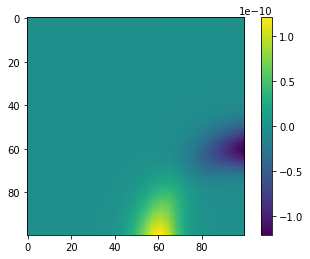

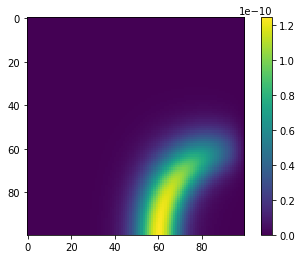

In [109]:
# I would expect this to be symmetric, but it isnt!!
plt.imshow(clpsigal2[10]-clpsigal2[10].T)
plt.colorbar()
plt.show()
plt.imshow(clpsigal2[10])
plt.colorbar()

In [110]:
# clphidelta 2d
try: 
    assert(False)
    clphidelta = np.load('../G_matrices/cldeltaphi_%s_2d.npy'%(file_ext2))
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    # chimax and kernels
    def lensing_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi)*(xmax > xi)*(1.+z_chi(xi))

    n = 2

    begin=time.time()
    
    result=np.zeros((len(t_),len(ell_),len(t_)))
    
    for jj, tt in enumerate(t_):
        if jj%10==0:
            print(jj)
        chi1fac0 =  D_chi(r2d*chimax)
        chi1fac0 =  chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))
        # only change chimax in lensing kernel -> sampling of integral suboptimal
        # do r2d*chimax -> r2d*chimax*tt everywhere
        chi2fac00 = (lensing_kernel(t2d*r2d*tt*chimax,chimax*r2d*tt)*D_chi(r2d*t2d*tt*chimax))
        chi2fac01 = (lensing_kernel(1./t2d*tt*r2d*chimax,chimax*r2d*tt)*D_chi(r2d/t2d*tt*chimax))
        chi2fac01 = chi2fac01 * (t2d)**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        for ii  in range(ell_.size):        
            result[jj][ii] = np.sum(chifacs*I2_ltrc[ii], axis=(0,2))


    clphidelta = -2*result*1./np.pi**2/2.*prefac/2. #no chimax*tt because no integration over r2d, will be in the outer integral
    
    # delta goes as r2d
    clphidelta = np.swapaxes(clphidelta,0,1)

    print('Time taken = ', time.time()-begin)


    np.save('../G_matrices/cldeltaphi_%s_2d.npy'%(file_ext2),clphidelta)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  149.65347337722778


In [117]:
# this is the first term in <1,3b>
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi)*(xmax > xi)

try:
    assert(False)
    _ , Mgg13bA = np.load('../M_matrices/Mgg13bA_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            # first index is L
            result[ii][jj] = np.sum(w11*w12*r2d*lensing_kernel(t2d*r2d*chimax,r2d*chimax)*kernel1(r2d*chimax)*cldeltaphi[jj]*clpsigal2[ii])
    result*=chimax**2/4.*2 #the last times two comes from the actual expression

    Mgg13bA = result

    # first index is L
    np.save('../M_matrices/Mgg13bA_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg13bA])

Mgg13bA_spline = RectBivariateSpline(ell_,ell_,Mgg13bA)

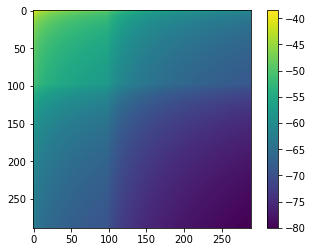

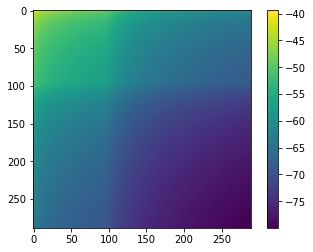

In [122]:
#significance difference between taking clpsigal2[ii].T and clpsigal2[ii]!!
plt.imshow(np.log(-Mgg13bA_))
plt.colorbar()
plt.show()
plt.imshow(np.log(-Mgg13bA))
plt.colorbar()

In [124]:
# clpsigalaxy, kernel1
try:
    assert(False)
    clpsigal1 = np.load('../G_matrices/clpsigal_%s_2d_kernel1.npy'%(file_ext))
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    # chimax and kernels

    n = 2
    
    begin=time.time()
    result=np.zeros((len(t_),len(ell_),len(t_)))
    
    for jj, tt in enumerate(t_):
        if jj%10==0:
            print(jj)
            
        chi1fac0 = D_chi(r2d*chimax*tt)*(1.+z_chi(r2d*chimax*tt))
        chi1fac0 = chi1fac0*(r2d*chimax*tt)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (kernel1(t2d*r2d*chimax*tt)*D_chi(r2d*t2d*chimax*tt))
        chi2fac01 = (kernel1(1./t2d*r2d*chimax*tt)*D_chi(r2d/t2d*chimax*tt))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0
        
        for ii  in range(ell_.size):        
            result[jj][ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))

    clpsigal  = result*1./np.pi**2/2.*prefac/2.
    clpsigal  = np.swapaxes(clpsigal,0,1)
    #t as second entry
    clpsigal1 = clpsigal#np.swapaxes(clpsigal,1,2)

    print('Time taken = ', time.time()-begin)


    np.save('../G_matrices/clpsigal_%s_2d_kernel1.npy'%(file_ext),clpsigal1)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  153.7883162498474


In [125]:
# this is the second term in <1,3b>
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi)*(xmax > xi)

try:
    assert(False)
    _ , Mgg13bB = np.load('../M_matrices/Mgg13bB_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            # first index is L
            result[ii][jj] = np.sum(w11*w12*r2d*lensing_kernel(t2d*r2d*chimax,r2d*chimax)*kernel2(r2d*chimax)*cldeltaphi[jj]*clpsigal1[ii])
    result*=chimax**2/4.*2 #the last times two comes from the actual expression in the draft

    Mgg13bB = result

    # first index is L
    np.save('../M_matrices/Mgg13bB_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg13bB])

Mgg13bB_spline = RectBivariateSpline(ell_,ell_,Mgg13bB)

In [126]:
Mgg13b_spline = RectBivariateSpline(ell_,ell_,Mgg13bB+Mgg13bA)

In [127]:
def get_regularized_sum_of_terms_11(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M1(L_,LL1,grid=False)+M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


def get_regularized_sum_of_terms_22(L,L1,phi,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*((LL*LL1*nu)**2-(LL*LL1*nu-LL1*LL1)**2)*(M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

def get_noLimber22_term(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M(L_,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

def get_noLimber13_term(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*(LL*LL1*nu)**2*(M(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

In [128]:
NoLimberTerms = get_regularized_sum_of_terms_11(L,l,phi,Mgg22B_spline,Mgg13b_spline,method='trapz')+get_regularized_sum_of_terms_22(L,l,phi,Mgg13b_spline,method='trapz')
NoLimberTerm1 = get_noLimber22_term(L,l,phi,Mgg22B_spline)
NoLimberTerm2 = get_noLimber13_term(L,l,phi,Mgg13b_spline)

(2, 1000.0)

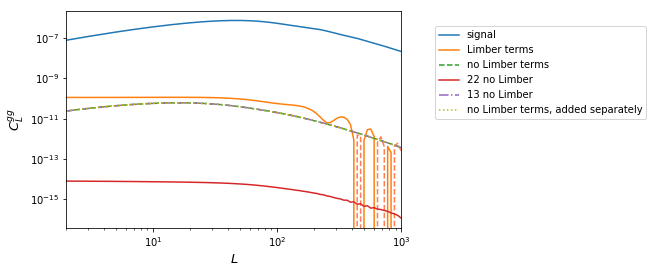

In [135]:
plt.figure()
plt.plot(ell_,Cl_gg, label='signal')
plt.plot(L,LimberTerms, label='Limber terms')
plt.plot(L,-LimberTerms,ls='--', color='coral')
#plt.plot(L,NoLimberTerms)
plt.plot(L,-NoLimberTerms,ls='--', label='no Limber terms')
plt.plot(L,NoLimberTerm1,ls='-',label='22 no Limber')
plt.plot(L,-NoLimberTerm2,ls='-.',label='13 no Limber')
plt.plot(L,-(NoLimberTerm2+NoLimberTerm1),ls=':',color='y',label='no Limber terms, added separately')
plt.ylabel('$C_L^{gg}$',fontsize=13)
plt.xlabel('$L$',fontsize=13)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=(1.1,0.5))
plt.xlim(2,max(L))